In [3]:
import csv
import numpy as np

import matplotlib

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0) # bigger figure!

from scipy import stats
import pandas as pd
import json
import seaborn as sns

# raincloud plots: https://github.com/RainCloudPlots/RainCloudPlots
import ptitprince as pt
import copy
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.rc('font', **font)

In [31]:
df=pd.read_csv("df.csv")
path = "./figs/"
saving = True
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.rc('font', **font)
                    
def expend_frame(data,x,y,hue):
    col = [l for l in list(data) if y in l]
    d={x:[],y:[],hue:[]}
    for i,c in enumerate(col):
        d[x]=d[x]+ [str(i+1)] * len(data)
        d[y]=d[y]+data[c].tolist()
        d[hue]=d[hue]+data[hue].tolist()
    return pd.DataFrame(d)

def plot(d,x,y,hue,xlabel,ylabel,palette=["deepskyblue", "#F7C544", "#0AB234"],legend=True,saving=False,line=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    sns.violinplot(x=x, y=y, hue=hue, data=d, split=False, inner=None, palette=palette,ax=ax1,saturation=.9)
    sns.swarmplot(x=x, y=y, hue=hue, data=d, dodge=True, palette=["black", "black","black"],ax=ax1)

    ma=max(d[y].values)
    mi=min(d[y].values)
    if mi > 0 and mi < .2*ma:
        ax1.set_ylim(0,1.1*ma)
        ax2.set_ylim(0,1.1*ma)
    else:
        ax1.set_ylim(mi-.05*ma,1.05*ma)
        ax2.set_ylim(mi-.05*ma,1.05*ma)
    
    ax1.set_xlabel(xlabel, **font)
    ax1.set_ylabel("", **font)
    sns.pointplot(x=x, y=y, hue=hue, data=d, palette=palette,ax=ax2)
    
    #ax2.set_yticklabels(ax1.get_yticklabels())
    ax2.set_xlabel(xlabel, **font)
    ax2.set_ylabel(ylabel+"\n", **font)
    ax2.yaxis.tick_right()
    
    if legend:
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        l = ax2.legend(handles1[0:3], labels2[0:3], loc='upper left',prop={'size': 13})
        ax1.legend_.remove()
    if line:
        ax1.axhline(y=line, color='r', linestyle='--', zorder=20)
        ax1.axhline(y=line, color='r', linestyle='--', zorder=-20)
        ax2.axhline(y=line, color='r', linestyle='--', zorder=20)
    if saving:
        f.savefig(path+y+".pdf",bbox_inches="tight")
                
    plt.show()    

def analyse(data,x,y,hue,xlabel,ylabel,palette=["deepskyblue", "#F7C544", "#0AB234"],legend=True,saving=False,line=None):
    d=expend_frame(data,x,y,hue)
    plot(d,x,y,hue,xlabel,ylabel,palette,legend,saving,line)
    

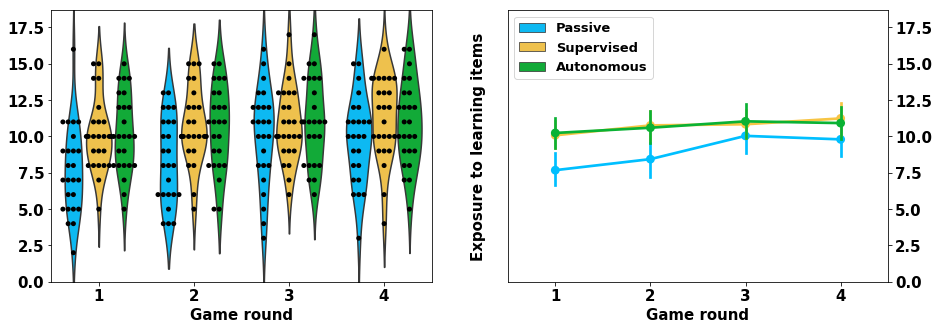

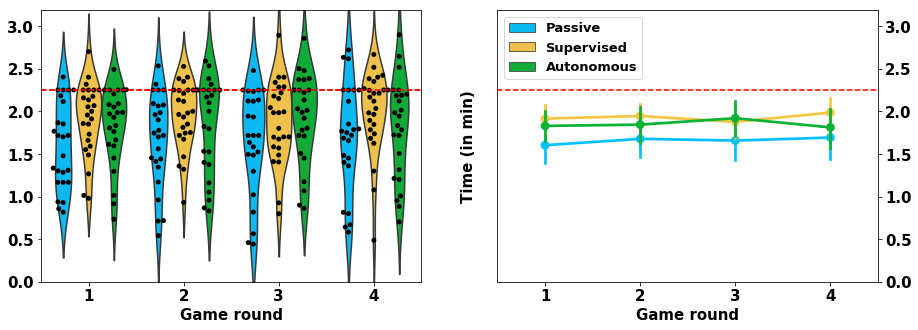

In [32]:
analyse(df,"Game","d_eat","condition","Game round","Exposure to learning items",saving=saving)
analyse(df,"Game","time","condition","Game round","Time (in min)", saving=saving,line=2.25)


In [7]:
# Tables
# Print latex tables
def print_table(di,x,y,hue,xlabel, ylabel,col_labels=None,cat=None):
    if col_labels is None:
        d=expend_frame(di,x,y,hue)
    else:
        d={x:[],y:[],hue:[]}
        for i,c in enumerate(cat):
            d[x]=d[x]+ [c] * len(di)
            d[y]=d[y]+di[c].tolist()
            d[hue]=d[hue]+di[hue].tolist()
        d=pd.DataFrame(d)
        
    print(ylabel)
    col= d[x].unique()
    rows=d[hue].unique()
    
    s=""
    if col_labels is None:
        for i in col:
            s+=" & "+(xlabel.split(" ")[-1]).capitalize() + " "+i
    else:
        for i in col_labels:
            s+=" & "+i
    s+="\\\\ \n \midrule \n"

    for r in rows:
        s+=r
        for i in col:
            m=d.loc[(d[x]==i) & (d[hue]==r)][y].mean()
            std=d.loc[(d[x]==i) & (d[hue]==r)][y].std()
            n=1
            if m<2:
                n=2
            s+=" & "+str(round(m,n))
            s+=" ("+str(round(std,n))+")"
        s+="\\\\ \n"

    print(s)
    
sub_frame = df.loc[(df["condition"]=="Supervised") | (df["condition"]=="Autonomous")]
action_categories=["att","mvc","mva", "mvt", "congrats", "encour", "rul"]
action_labels=["Drawing attention","Move close", "Move away", "Move to", "Congratulations", "Encouragements","Remind rules"]

print_table(df,"Game","d_eat","condition","Game round","Exposure to learning items")
print_table(df,"Game","time","condition","Game round","Time")

Exposure to learning items
 & Round 1 & Round 2 & Round 3 & Round 4\\ 
 \midrule 
Passive & 7.7 (3.0) & 8.4 (2.9) & 10.0 (3.3) & 9.8 (3.0)\\ 
Supervised & 10.1 (2.5) & 10.8 (2.6) & 10.8 (2.5) & 11.2 (2.8)\\ 
Autonomous & 10.2 (2.7) & 10.6 (2.9) & 11.0 (2.9) & 10.9 (2.9)\\ 

Time
 & Round 1 & Round 2 & Round 3 & Round 4\\ 
 \midrule 
Passive & 1.6 (0.5) & 1.68 (0.54) & 1.66 (0.6) & 1.69 (0.63)\\ 
Supervised & 1.91 (0.42) & 1.94 (0.39) & 1.88 (0.48) & 1.98 (0.49)\\ 
Autonomous & 1.83 (0.46) & 1.84 (0.55) & 1.92 (0.52) & 1.81 (0.58)\\ 



In [8]:
#Learning gain
cs=["Passive","Supervised","Autonomous"]
for c in cs:
    m=df.loc[df["condition"]==c].learning.mean()
    std=df.loc[df["condition"]==c].learning.std()
    n=1
    if m<2:
        n=2
    s=c+" "+str(round(m,n))
    s+=" ("+str(round(std,n))+")"
    print s

Passive 0.12 (0.14)
Supervised 0.11 (0.13)
Autonomous 0.14 (0.12)


In [9]:
#Demographics
print "Age: "+str(np.mean(df["age"])) +" ("+str(round(np.std(df["age"]),2))+")"
print str(np.sum(df["gender"]=="female"))+"F/"+str(np.sum(df["gender"]=="male"))+"M"

Age: 9.4 (0.71)
37F/38M


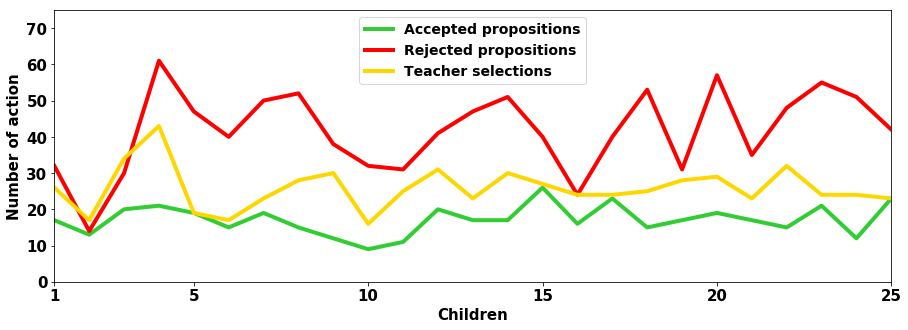

In [10]:
# Supervisor and robot learning

with open("supervisor.json",'r') as f:
    d=json.load(f)
ratio=[]
ratio_accepted=[]
ratio_canceled=[]
good_sug=[]
total_sel=[]
n_proposed=np.zeros(len(d))
n_skip=np.zeros(len(d))
n_press=np.zeros(len(d))
n_autoexe=np.zeros(len(d))
n_enforced=np.zeros(len(d))
n_doit=np.zeros(len(d))
n_select=np.zeros(len(d))
n_reenforced=np.zeros(len(d))
n_cancel=np.zeros(len(d))
n_remove=np.zeros(len(d))

for i, a in enumerate(d):
    n_proposed[i]=len(a["proposed"])
    n_skip[i]=len(a["skip"])
    n_press[i]=len(a["press"])
    n_autoexe[i]=len(a["autoexe"])
    n_enforced[i]=len(a["enforced"])
    n_reenforced[i]=len(a["reenforced"])
    n_doit[i]=len(a["doit"])
    n_select[i]=len(a["select"])
    n_cancel[i]=len(a["cancel"])
    n_remove[i]=len(a["remove"])
    
saving=True
f=plt.figure(figsize=(15,5))
x=np.arange(25)+1
n_good=n_autoexe+n_enforced+n_doit+n_reenforced
n_bad=n_cancel + n_remove + n_skip - n_reenforced
n_teacher = n_select - n_reenforced - n_enforced
n_good_child=np.zeros(len(n_good)/4)
n_bad_child=np.zeros(len(n_bad)/4)
n_teacher_child=np.zeros(len(n_teacher)/4)
for i in range(len(n_good_child)):
    n_good_child[i]=n_good[4*i]+n_good[4*i+1]+n_good[4*i+2]+n_good[4*i+3]
    n_bad_child[i]=n_bad[4*i]+n_bad[4*i+1]+n_bad[4*i+2]+n_bad[4*i+3]
    n_teacher_child[i]=n_teacher[4*i]+n_teacher[4*i+1]+n_teacher[4*i+2]+n_teacher[4*i+3]

plt.plot(x,n_good_child,'limegreen',linewidth=4, label="Accepted propositions")
plt.plot(x,n_bad_child,'r',linewidth=4, label="Rejected propositions")
plt.plot(x,n_teacher_child,'gold',linewidth=4, label="Teacher selections")
plt.ylabel("Number of action",**font)
plt.xlabel("Children",**font)
plt.legend(prop={'size': 14}, loc="upper center")
plt.xticks(list(plt.xticks()[0]) + [1])
plt.xlim(1,25)
plt.ylim(0,75)

if saving:
    f.savefig(path+"summary_supervision.pdf",bbox_inches="tight")
plt.show()

In [11]:
#Mean and standard deviation of actions

print str(round(np.mean(n_good_child),1))+" ("+str(round(np.std(n_good_child),1))+")"
print str(round(np.mean(n_bad_child),1))+" ("+str(round(np.std(n_bad_child),1))+")"
print str(round(np.mean(n_teacher_child),1))+" ("+str(round(np.std(n_teacher_child),1))+")"

g=np.sum(n_good_child)
b=np.sum(n_bad_child)

17.2 (4.0)
41.7 (11.1)
25.8 (5.8)


In [33]:
def half_violin_plot(data, x, hue, y, offset_box, offset_violin, x_tick_labels, y_label,max_y,name=None):
    palette=[ "#F7C544", "#0AB234"]
    f, (ax) = plt.subplots(1, 1,figsize=(20,7))
    local_font=copy.copy(font)
    local_font["size"]+=1

    sns.stripplot(x=x, y=y, hue=hue, data=data,dodge=True,palette=palette, jitter=True,zorder=-1)
    bplot=sns.boxplot(x=x, y=y, hue=hue, data=data,dodge=True,palette=palette,linewidth=3,
                      width=.24,whis=1.5,zorder=5,boxprops={'facecolor':'None'}, fliersize=0)
    t = matplotlib.transforms.Affine2D().translate(offset_box,0)
    for i in range(len(x_tick_labels)):
        bplot.artists[2*i].set_transform(bplot.artists[2*i].get_transform() - t)
        bplot.artists[2*i+1].set_transform(bplot.artists[2*i+1].get_transform() + t)
        n=6
        for j in range(n):
            bplot.lines[2*i*n+j].set_transform(bplot.lines[2*i*n+j].get_transform() - t)
            bplot.lines[(2*i+1)*n+j].set_transform(bplot.lines[(2*i+1)*n+j].get_transform() + t)
    pt.half_violinplot(x=x, y=y, data=data, hue=hue, palette=palette, cut = 2, bw=.5,
                      scale="area", width=.8, inner = None, orient="v", offset=offset_violin,saturation=.9)
    
    handles, labels = ax.get_legend_handles_labels()
    l = ax.legend(handles[0:2], labels[0:2], loc='upper left',prop={'size': local_font["size"]})
    
    locs, labels = plt.xticks()
    plt.xticks(locs, x_tick_labels, rotation=0,**local_font)
    plt.xlabel("", **local_font)
    local_font["size"]+=3
    plt.ylabel(y_label, **local_font)
    plt.ylim([-1,max_y])
    plt.show()
    if name:
        f.savefig(path+name,bbox_inches="tight")
    

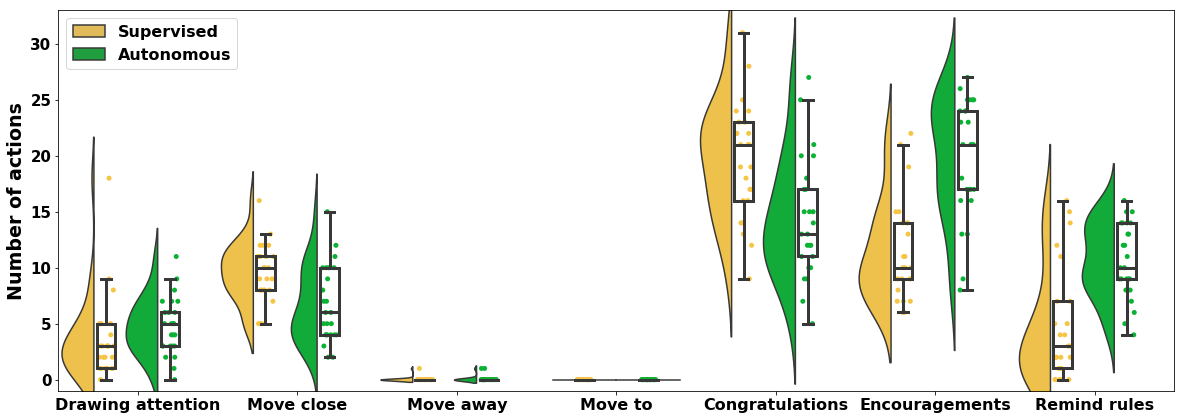

In [34]:
# Graphs
data = df.loc[(df["condition"]=="Supervised") | (df["condition"]=="Autonomous")]
hue="condition"
x="action"
y="number"
d={x:[],y:[],hue:[]}
action_categories=["att","mvc","mva", "mvt", "congrats", "encour", "rul"]
for i,c in enumerate(action_categories):
    d[x]=d[x]+ [c] * len(data)
    d[y]=d[y]+data[c].tolist()
    d[hue]=d[hue]+data[hue].tolist()
data=pd.DataFrame(d)
x_tick_labels=["Drawing attention","Move close", "Move away", "Move to", "Congratulations", "Encouragements","Remind rules"]
offset_box=22.5
y_label = "Number of actions"
name=None
offset_violin=0.08
name="raincloud_actions.pdf"
half_violin_plot(data, x, hue, y, offset_box, offset_violin, x_tick_labels, y_label,max_y=33,name=name)

In [35]:
action_id =["att","mvc","mva","mvt","congrats","encour","rul"]

with open('sup_event.csv') as f:
    l=[]
    r = csv.reader(f, delimiter=";")
    for row in r:
        l.append(row)
    sup_event=[]
    for r_num,row in enumerate(l):
        for i in range(25):
            for j in range(4):
                c=[row[2*(4*i+j)],row[2*(4*i+j)+1]]
                if r_num==0:
                    if j==0:
                        sup_event.append([[c]])
                    else:
                        sup_event[i].append([c])
                else:
                    if c != ["",""]:
                        sup_event[i][j].append(c)
    
with open('aut_event.csv') as f:
    l=[]
    r = csv.reader(f, delimiter=";")
    for row in r:
        l.append(row)
    aut_event=[]
    count=0
    for r_num,row in enumerate(l):
        for i in range(25):
            for j in range(4):
                c=[row[2*(4*i+j)],row[2*(4*i+j)+1]]
                if c[1]=="congrats":
                    count+=1
                if r_num==0:
                    if j==0:
                        aut_event.append([[c]])
                    else:
                        aut_event[i].append([c])
                else:
                    if c != ["",""]:
                        aut_event[i][j].append(c)
def get_time_between(data, ev1, ev2):    
    t=0
    ts=[]
    for c in data:
        for r in c:
            t=None
            for event in r:
                if event[1].startswith(ev2) and t is not None:
                    ts.append(float(event[0])-float(t))    
                if event[1].startswith(ev1):
                    t=event[0]
    return ts

def get_frame_time(event_list):
    d_e={"type":[],"time":[],"condition":[]}
    for i in event_list:
        t1=get_time_between(sup_event,i[0],i[1])
        t2=get_time_between(aut_event,i[0],i[1])

        for t in t1:
            d_e["type"].append(i[0]+"_"+i[1])
            d_e["time"].append(t)
            d_e["condition"].append("Supervised")
        for t in t2:
            d_e["type"].append(i[0]+"_"+i[1])
            d_e["time"].append(t)
            d_e["condition"].append("Autonomous")

    return pd.DataFrame(d_e)

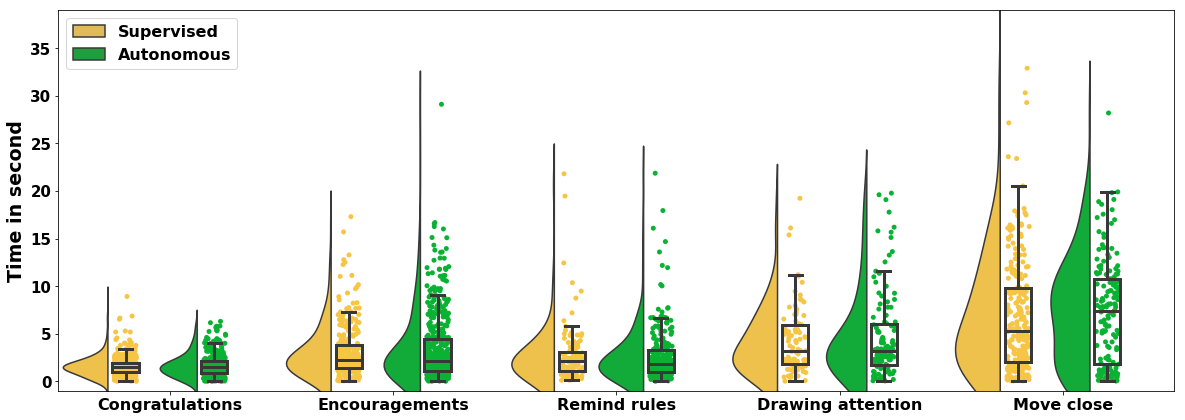

In [36]:
events=["animaleat"]
actions=["cong","enc","rul","att","mvc"]
data=get_frame_time([["animaleat",a] for a in actions])

x="type"; hue="condition"; y="time"; offset_box=31
x_tick_labels=[ "Congratulations", "Encouragements","Remind rules", "Drawing attention","Move close"]
y_label = "Time in second"
name="timing_actions_animal_eat.pdf"
max_y=39;offset_violin=0.08
half_violin_plot(data, x, hue, y, offset_box, offset_violin, x_tick_labels, y_label, max_y,name=name)